# Zillow Home Value Estimator - Regression Project Presentation
#### By Codeup student Jason R. Turner - June 9, 1986
***

## Project Overview
***
- Create README.md with project objectives, business goals, data dictionary, hypotheses, summary and how to reproduce project.
- Create functions to acquire data from the Codeup Database in an wrangle.py file to import into the Final Report Notebook.
- Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
- Clearly define two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- Establish a baseline accuracy and document well.
- Train three different classification models.
- Evaluate models on train and validate datasets.
- Choose the model with that performs the best and evaluate that single model on the test dataset.
- Create csv file with the tax value dollar count, the probability of the target values, and the model's prediction for each observation in my test dataset.
- Document conclusions, takeaways, and next steps in the Final Report Notebook.
***

## Executive Summary - Key Findings & Next Steps
***
- 



***

In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os
import sklearn.preprocessing
from math import sqrt
import wrangle
import util
import env

# Modeling imports
from sklearn.metrics import classification_report, mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import PolynomialFeatures



***
### Acquire Data
***

In [2]:
# read zillow data into a DataFrame that's split into train, validate, and test sets
zillow_df = wrangle.get_zillow_data()

In [3]:
print(f'This dataframe has {zillow_df.shape[0]} rows and {zillow_df.shape[1]} columns')

This dataframe has 52442 rows and 7 columns


#### Acquire Takeaways
- I wrote a sql query to acquire my data from the Codeup database.
- I'm importing my get_zillow_data function from my wrangle.py file that will create a local csv file if one doesn't exist already for future use.
- I'm bringing in 52442 rows and 7 columns on my initial acquisition.
- My numeric columns have different units of measure, bedrooms, bathrooms, sq ft, dollars, years, and a number represting the county
- There is substantial difference in the value ranges of columns other than yearbuilt.

***
### Prepare Data
- Built functions for preparing data zillow dataframe ultimately stored in my wrangle.py file.

***

In [4]:
pd.isnull(zillow_df).sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
lotsizesquarefeet               369
taxvaluedollarcnt                 1
yearbuilt                       116
fips                              0
dtype: int64

In [5]:
round(zillow_df.dropna().shape[0] / zillow_df.shape[0], 4)

0.9908

In [6]:
wrangle.clean_zillow(zillow_df).head(0)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,yearbuilt,fips,county


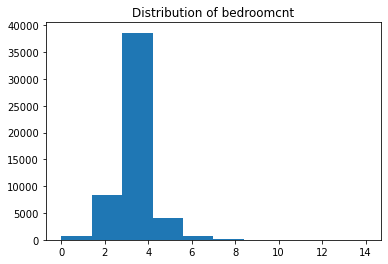

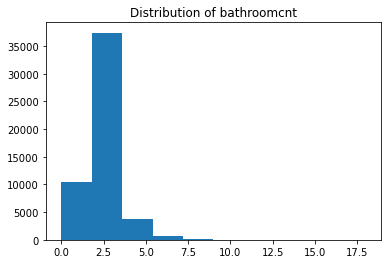

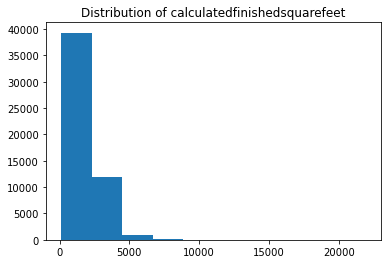

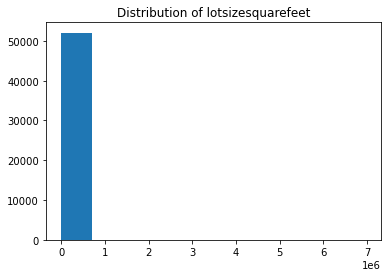

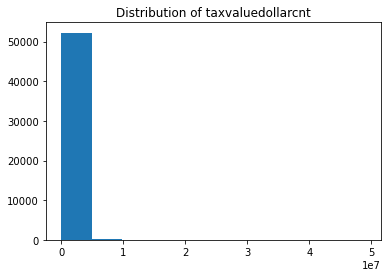

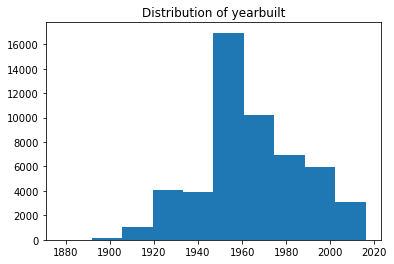

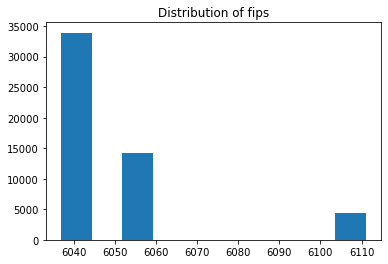

In [7]:
util.num_distribution(zillow_df)

In [8]:
train, validate, test = wrangle.wrangle_zillow()

In [9]:
print(f'train is {train.shape[0]} rows and {train.shape[1]} columns')
print(f'validate is {validate.shape[0]} rows and {validate.shape[1]} columns')
print(f'test is {test.shape[0]} rows and {test.shape[1]} columns')

train is 24940 rows and 8 columns
validate is 16628 rows and 8 columns
test is 10392 rows and 8 columns


#### Prepare Takeaways
- I checked for any null values in the requested dataset, relatively few of which were found and subsequently dropped.
- The target class is a continuous variable and there are high value outliers for it.
- the values for the 'fips' column are values representing counties in California. I'll add a column called 'county' that has the respective county listed in English.
- The number of houses is weighted heavily in Los Angeles countie's favor, then Orange county Ventura county in descending order.
- The numeric values for calculatedfinishedsquarefeet, taxvaluedollarcnt, bedroomcnt, lotsizesquarefeet can be and were converted to integers without any data loss.
- I split my data into train, validate, and test datasets, stratified by county the fips column.

***
### Explore Data
***

In [10]:
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))

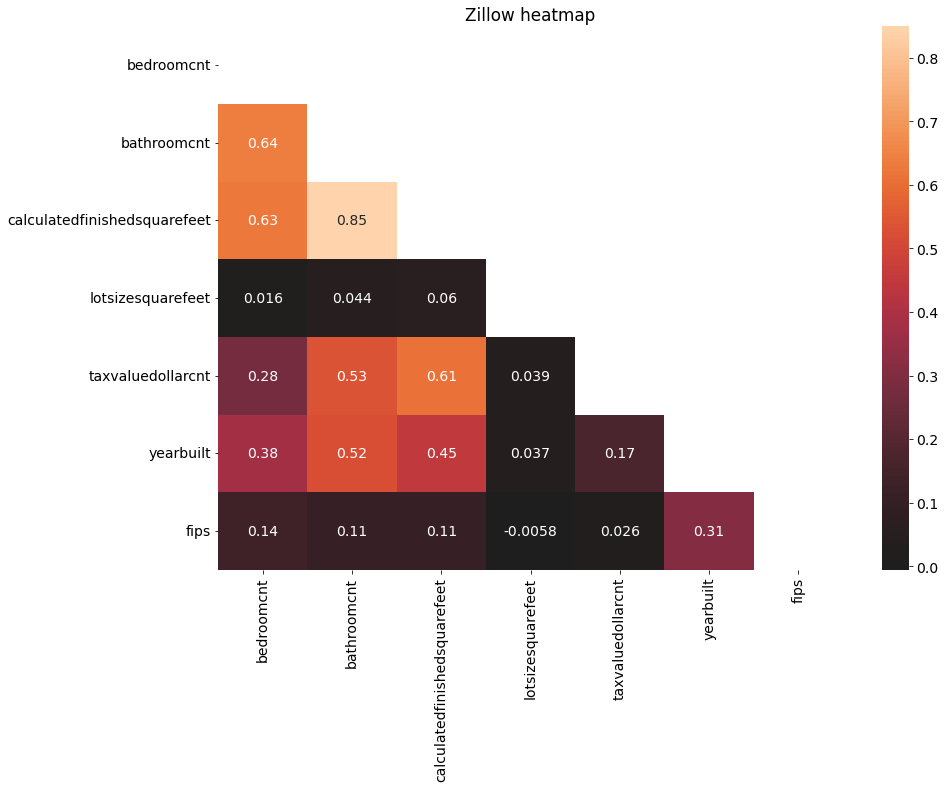

In [11]:
sns.heatmap(train.corr(), center=0, annot=True, mask=np.triu(train.corr()))

plt.title('Zillow heatmap')
plt.show()

##### Heatmap takeaways
- The strongest correlations are between the following:
    - The number of bathrooms and housing ft$^2$
    - The number of bedrooms with the number of bathrooms
    - The number of bedrooms and housing ft$^2$
    - The housing ft$^2$ and the tax value dollar count

Text(0.5, 1.0, 'House Tax Values Count vs Lot Size ft$^2$')

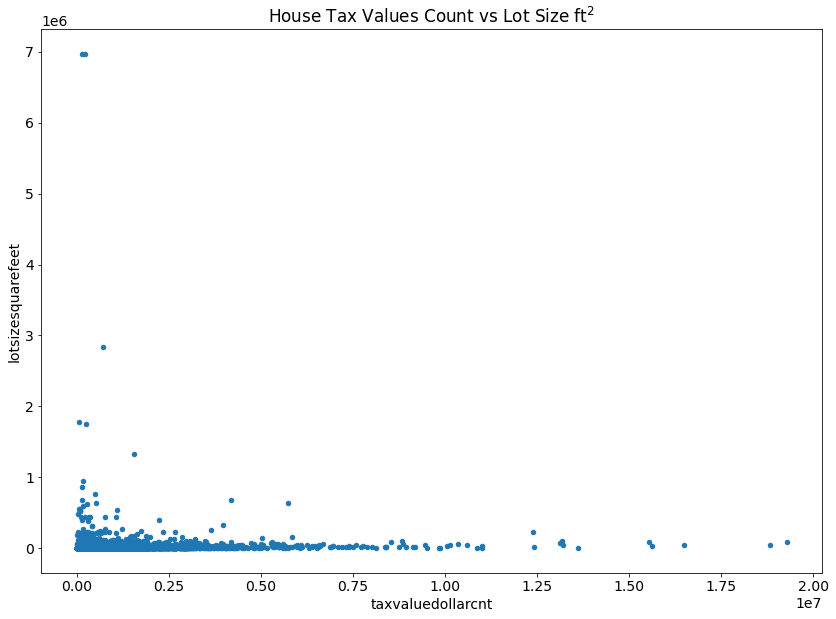

In [12]:
# visualizes distribution of correlation for tax value dollar count and lot size in a scatter plot
train.plot.scatter('taxvaluedollarcnt', 'lotsizesquarefeet')
plt.title('House Tax Values Count vs Lot Size ft$^2$')

Text(0.5, 1.0, 'House Tax Values vs House Size in ft$^2$')

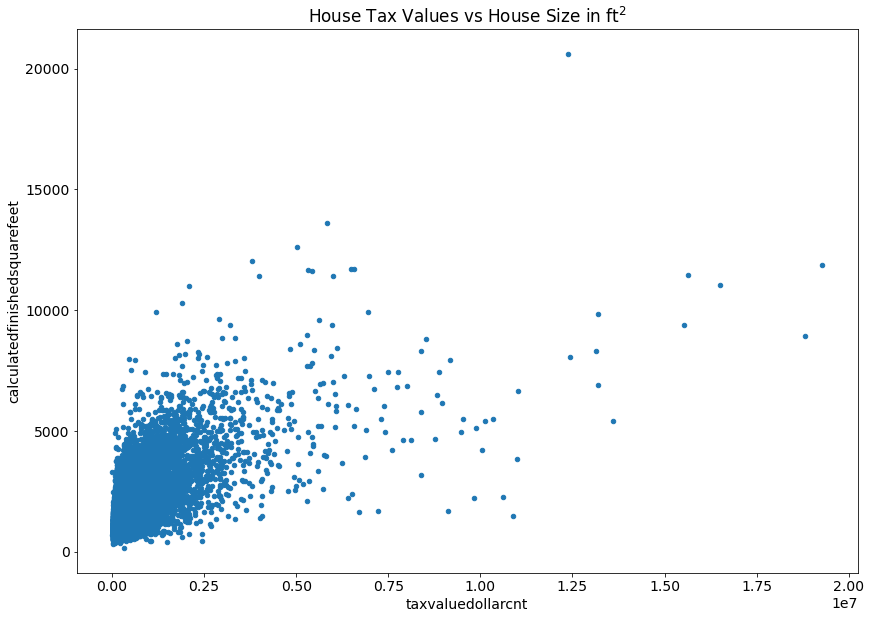

In [13]:
# visualizes distribution of correlation for tax value dollar count and lot size in a scatter plot
train.plot.scatter('taxvaluedollarcnt', 'calculatedfinishedsquarefeet')
plt.title('House Tax Values vs House Size in ft$^2$')

#### Statistical Testing
- **Hypothesis**

- alpha = .05

- $H_0$: There is no significant difference in property tax assessed values for different lot sizes

- $H_a$: There is a significant difference in property tax assessed values for different lot sizes

In [14]:
taxes = train.taxvaluedollarcnt
lot_size = train.lotsizesquarefeet

Text(0.5, 0, 'Lot Sizes')

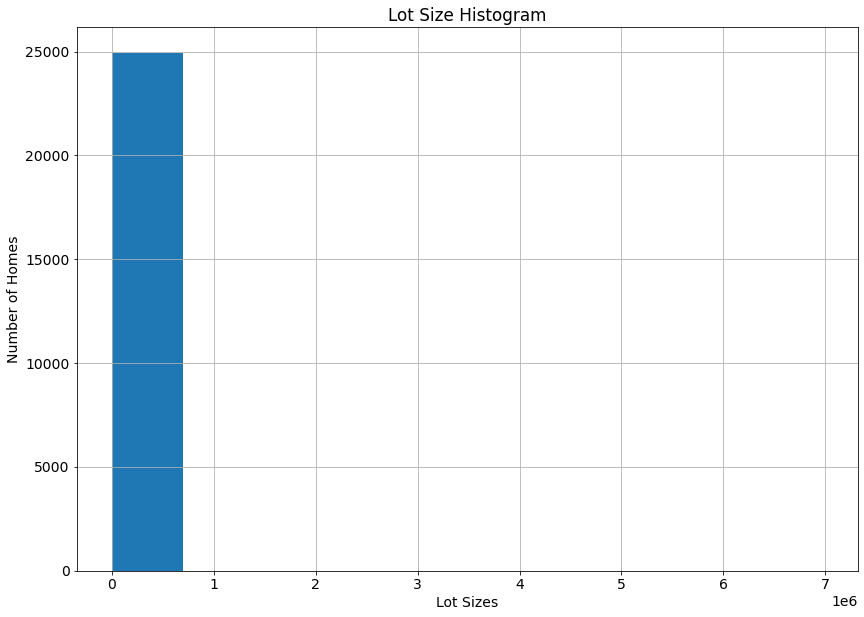

In [15]:
lot_size.hist()
plt.title('Lot Size Histogram')
plt.ylabel('Number of Homes')
plt.xlabel('Lot Sizes')

Text(0.5, 0, 'House Tax Values')

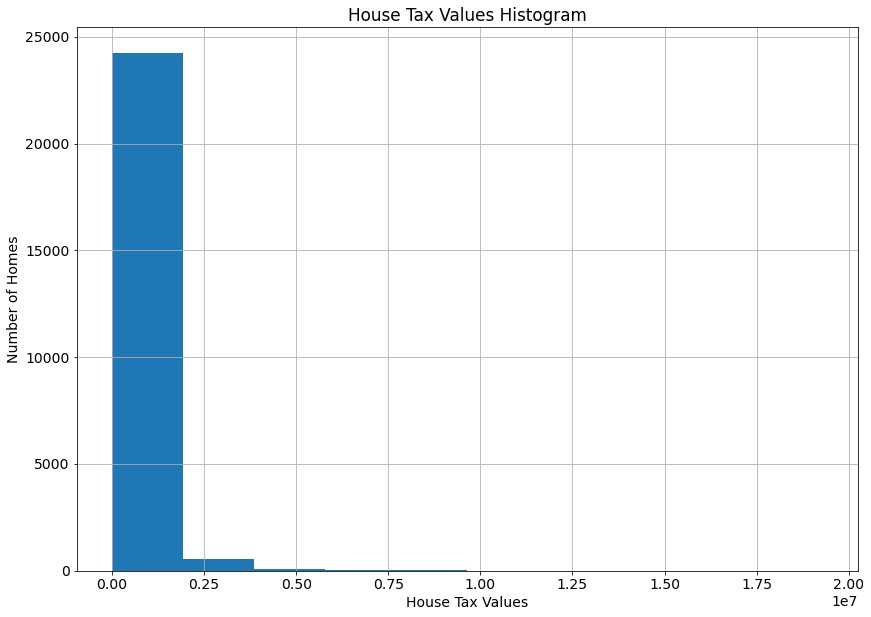

In [16]:
taxes.hist()
plt.title('House Tax Values Histogram')
plt.ylabel('Number of Homes')
plt.xlabel('House Tax Values')

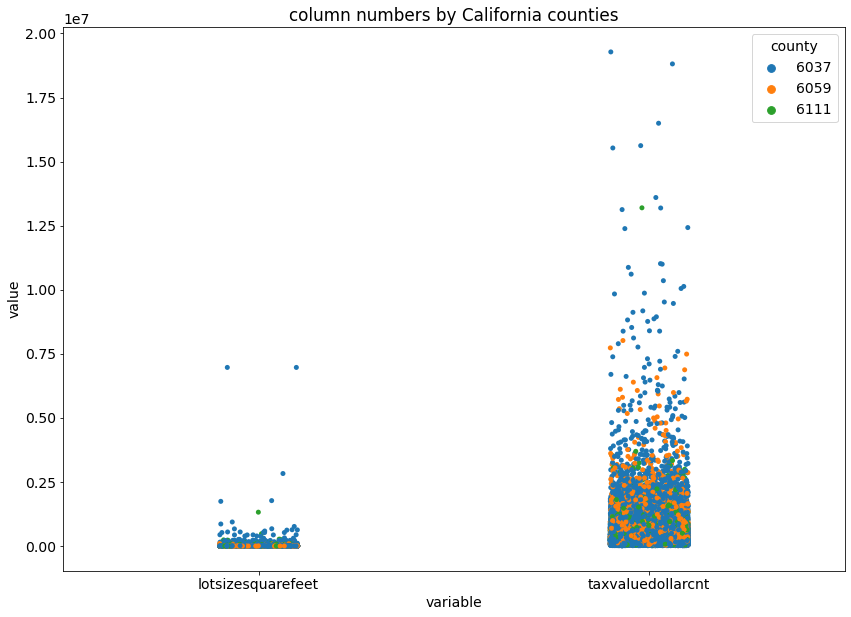

In [17]:
explore_train = train[['lotsizesquarefeet',
       'taxvaluedollarcnt', 'county']]
melted = explore_train.melt(id_vars=['county'])
sns.stripplot(data=melted, x='variable', y='value', hue='county')

plt.title('column numbers by California counties')

plt.show()

Normal Distribution assumption can be be met by having a large enough sample (due to Central Limit Theorem)

In [18]:
alpha = .05

In [19]:
t, p = stats.ttest_ind(taxes, lot_size, equal_var=False)
t, p / 2

(113.20535439342805, 0.0)

In [20]:
# 'if' statement to print out result of our null hypothesis
if p < alpha:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


Hypothesis Conclusion

- We reject $H_0$ that there is no significant difference in property tax assessed values to  lot sizes.

Takeaway

- Lot size is a statistically significant feature of the model.

- **Hypothesis 2**

- alpha = .05

- $H_0$: House tax values for a 1 bathroom house is equal to or greater than for a 2 bedroom house.
- $H_a$: House tax values for a 1 bathroom house is less than for a 2 bedroom house.

In [21]:
one_bath = train[train.bathroomcnt == 1].taxvaluedollarcnt
two_bed = train[train.bedroomcnt == 2].taxvaluedollarcnt

Text(0.5, 0, 'House Tax Values')

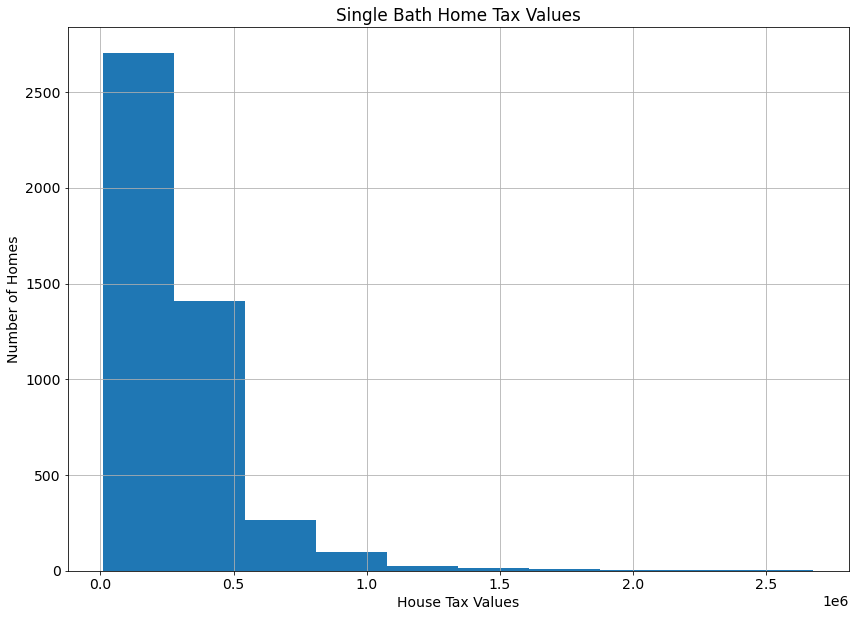

In [22]:
one_bath.hist()
plt.title('Single Bath Home Tax Values')
plt.ylabel('Number of Homes')
plt.xlabel('House Tax Values')

Text(0.5, 0, 'House Tax Values')

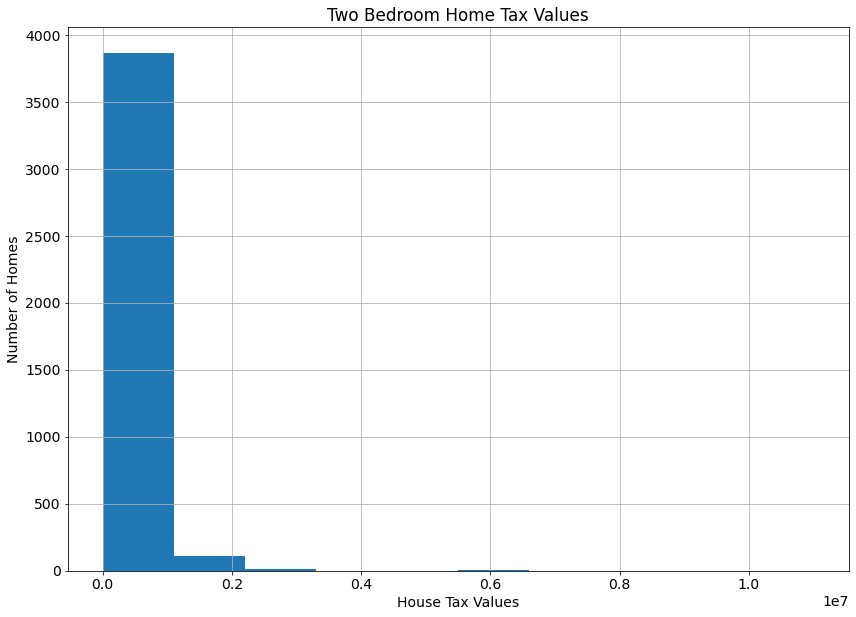

In [23]:
two_bed.hist()
plt.title('Two Bedroom Home Tax Values')
plt.ylabel('Number of Homes')
plt.xlabel('House Tax Values')

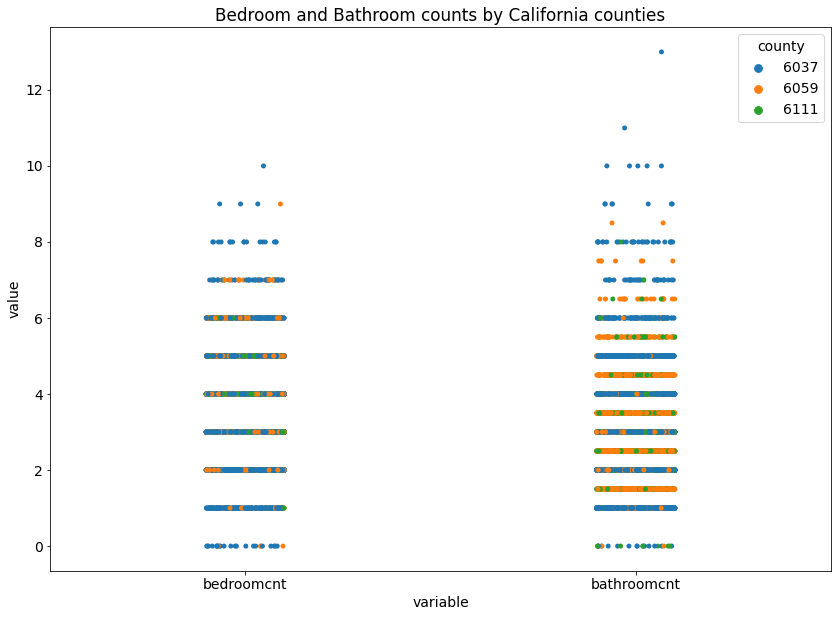

In [24]:
explore_train1 = train[['bedroomcnt', 'bathroomcnt', 'county']]

melted = explore_train1.melt(id_vars=['county'])

sns.stripplot(data=melted, x='variable', y='value', hue='county')

plt.title('Bedroom and Bathroom counts by California counties')

plt.show()

Normal Distribution assumption can be be met by having a large enough sample (due to Central Limit Theorem)

In [25]:
alpha = .05

In [26]:
t, p = stats.ttest_ind(one_bath, two_bed, equal_var=False)
t, p / 2

(-10.206764964233807, 1.4502201982359411e-24)

In [27]:
# 'if' statement to print out result of our null hypothesis
if p < alpha:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


Hypothesis 2 Conclusion

- We reject $H_0$ that having a 1 bathroom is equal to or greater than having 2 bedrooms in tax value dollars.

Takeaway

- Having a 1 bathroom is a statistically significant feature compared to having 2 bedrooms in regards to tax value dollars.

### Explore Takeaways
- Lot size seems to have a greater relative statistical probability for being a useful feature than having 1 bathroom.
- We should try using methods that or more resistant to large outliers.

***
### Modeling and Evaluation
***

#### Baseline

In [28]:
# splits our training set into x and y values to run in our algorithms
X_train = train.drop(columns=['taxvaluedollarcnt'])
y_train = train['taxvaluedollarcnt']

# splits our validate set into x and y values to run in our algorithms
X_validate = validate.drop(columns=['taxvaluedollarcnt'])
y_validate = validate['taxvaluedollarcnt']

# splits our test set into x and y values to run in our algorithms
X_test = test.drop(columns=['taxvaluedollarcnt'])
y_test = test['taxvaluedollarcnt']

In [29]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict y_pred_mean
y_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['y_pred_mean'] = y_pred_mean
y_validate['y_pred_mean'] = y_pred_mean

# 2. compute y_pred_median
y_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['y_pred_median'] = y_pred_median
y_validate['y_pred_median'] = y_pred_median

# 3. RMSE of y_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.y_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.y_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train,  
      "\nValidate/Out-of-Sample: ", rmse_validate)

# 4. RMSE of y_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.y_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.y_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", rmse_train,  
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Mean
Train/In-Sample:  714846.4893951517 
Validate/Out-of-Sample:  679928.9704606724
RMSE using Median
Train/In-Sample:  731339.777505064 
Validate/Out-of-Sample:  697159.4773275485


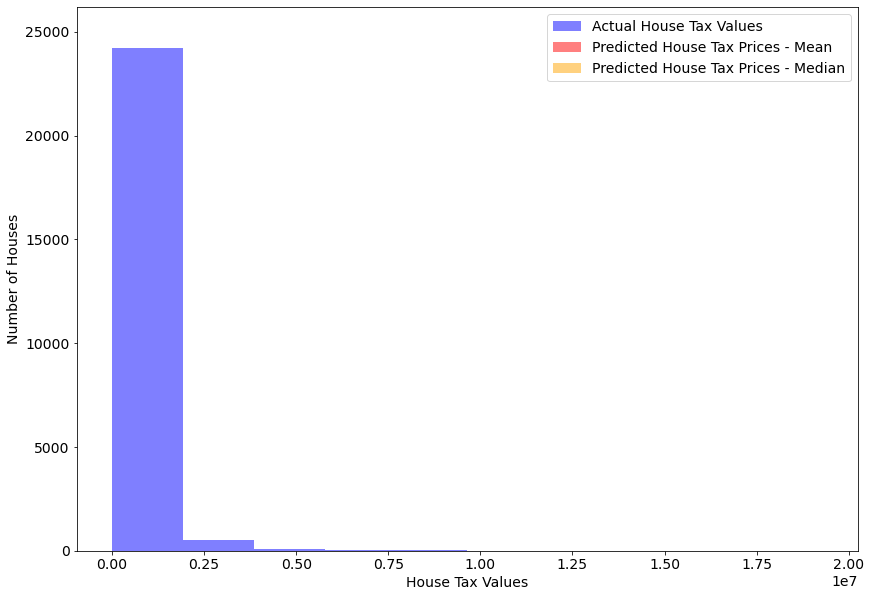

In [30]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual House Tax Values")
plt.hist(y_train.y_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted House Tax Prices - Mean")
plt.hist(y_train.y_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted House Tax Prices - Median")
plt.xlabel("House Tax Values")
plt.ylabel("Number of Houses")
plt.legend()
plt.show()


#### Linear Regression

In [31]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['y_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.y_pred_lm)**(1/2)

# predict validate
y_validate['y_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.y_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  547850.4164683106 
Validation/Out-of-Sample:  504465.28952567006


#### LassoLars

In [32]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['y_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.y_pred_lars)**(1/2)

# predict validate
y_validate['y_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.y_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  547850.6971460134 
Validation/Out-of-Sample:  504461.50259532017


#### TweedieRegressor

In [33]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['y_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.y_pred_glm)**(1/2)

# predict validate
y_validate['y_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.y_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  714846.4893951517 
Validation/Out-of-Sample:  679928.9704606724


#### Plotting Actual vs Predicted Values

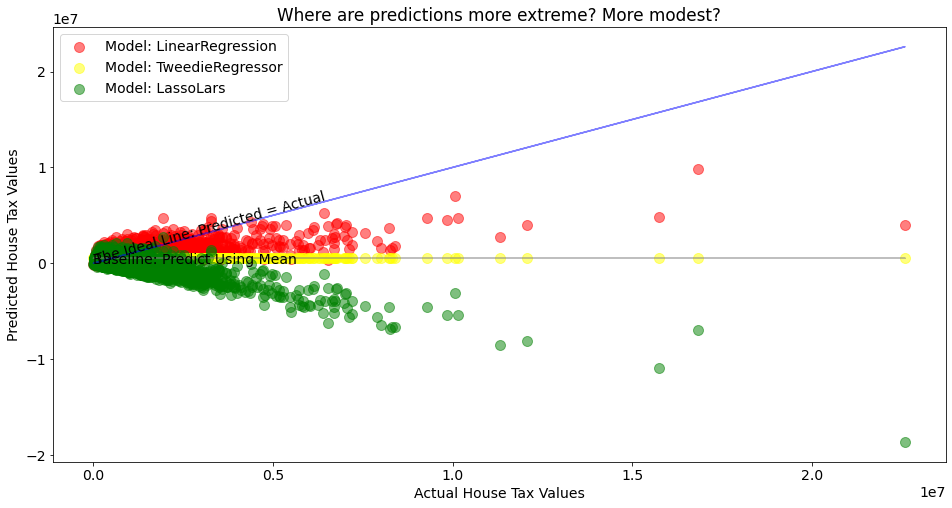

In [34]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.y_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.y_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.y_pred_lars-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="green", s=100, label="Model: LassoLars")

plt.legend()
plt.xlabel("Actual House Tax Values")
plt.ylabel("Predicted House Tax Values")
plt.title("Where are predictions more extreme? More modest?")

plt.show()


#### Residual Plots: Plotting Prediction Errors

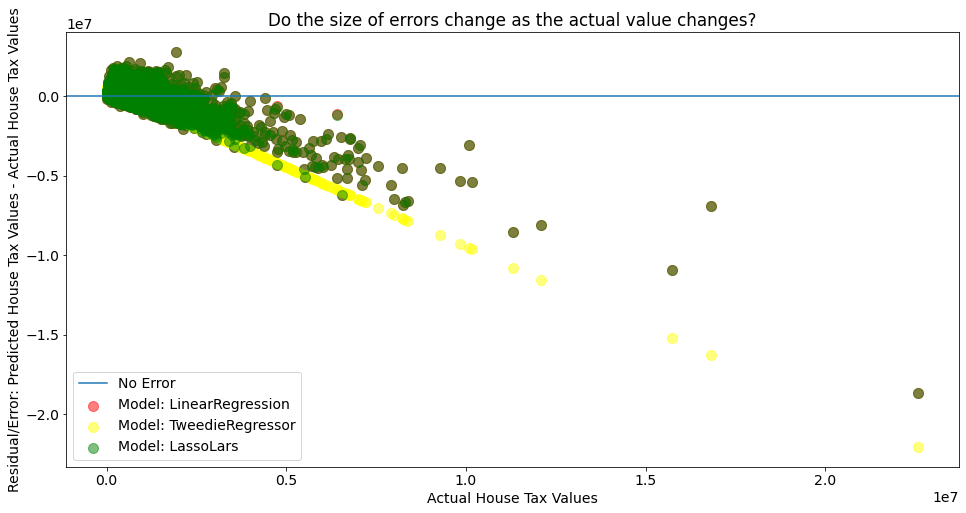

In [35]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.y_pred_lm-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.y_pred_glm-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.y_pred_lars-y_validate.taxvaluedollarcnt, 
            alpha=.5, color="green", s=100, label="Model: LassoLars")

plt.legend()
plt.xlabel("Actual House Tax Values")
plt.ylabel("Residual/Error: Predicted House Tax Values - Actual House Tax Values")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()


#### Histograms

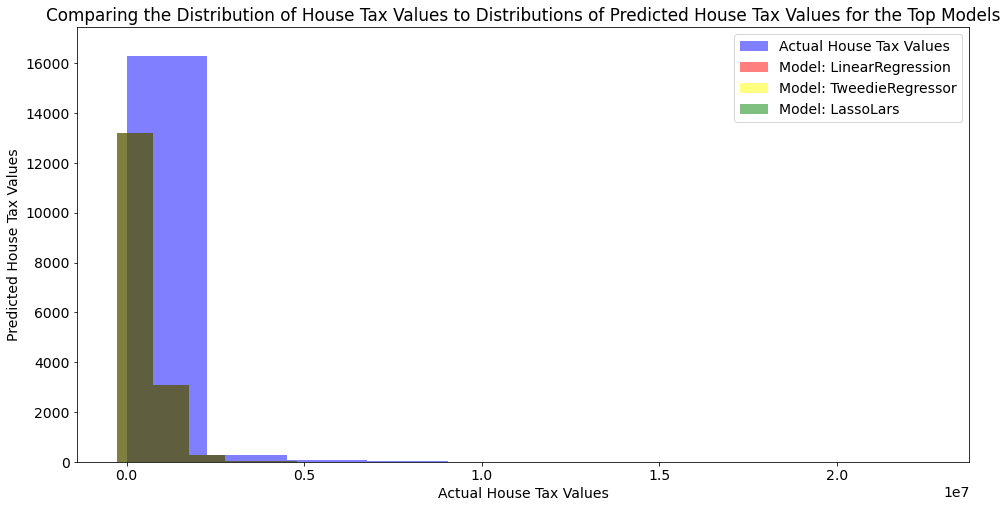

In [36]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual House Tax Values")
plt.hist(y_validate.y_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.y_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.y_pred_lars, color='green', alpha=.5, label="Model: LassoLars")
plt.xlabel("Actual House Tax Values")
plt.ylabel("Predicted House Tax Values")
plt.title("Comparing the Distribution of House Tax Values to Distributions of Predicted House Tax Values for the Top Models")
plt.legend()
plt.show()


#### MVP Models - Takeaways
- The Ordinary Least Squares Linear Regression barely edged out Lasso + Lars to become our best model
- The Tweedie Regressor Model and our Baseline means appear to have the same exacty values

#### Top Model Selected
- Linear Regression Model

In [37]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['y_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.y_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  625510.6098395705


## Conclusions and Next Steps
**Key Takeaways**
- There is a statistically significant but fairly low correlation between house tax value and lot size
- The house tax values for 1 bathroom homes are lower than for 2 bedroom homes on average
**Recommendations**
- For more up to date and accurate results I recommend finding out how much the homes actually sold for and the rate that sold throughout the year based on their location.
**With additional time**
- I would like to explore using different models in conjunction with their specific geographical coordinates and incorporating evaluations for years past as well as incorporating current prices for newly built homes that have not been on the market yet.